<a href="https://colab.research.google.com/github/sheikabra/algerian_forest_fire_prediction/blob/main/Algerian_Forest_Fire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algerian Forest Fire Problem
by Abrahim hussain

## Load Data

In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
algerian_forest_fires = fetch_ucirepo(id=547)

# data (as pandas dataframes)
X = algerian_forest_fires.data.features
y = algerian_forest_fires.data.targets

# metadata
print(algerian_forest_fires.metadata)

# variable information
print(algerian_forest_fires.variables)


{'uci_id': 547, 'name': 'Algerian Forest Fires', 'repository_url': 'https://archive.ics.uci.edu/dataset/547/algerian+forest+fires+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/547/data.csv', 'abstract': 'The dataset includes 244 instances that regroup a data of two regions of Algeria.', 'area': 'Biology', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 244, 'num_features': 14, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Classes  '], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2019, 'last_updated': 'Tue Mar 19 2024', 'dataset_doi': '10.24432/C5KW4N', 'creators': [' Faroudja Abid'], 'intro_paper': {'ID': 325, 'type': 'NATIVE', 'title': ' Predicting Forest Fire in Algeria Using Data Mining Techniques: Case Study of the Decision Tree Algorithm', 'authors': 'Faroudja Abid, N.Izeboudjen', 'venue': 'Ezziyyani M. (eds) Advanced Intelligent Systems

## Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sci
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score,mean_absolute_error, mean_squared_error, r2_score, accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
import time

#Preprocessing

## Cleaning The Labels

In [ ]:
y['Classes  '].unique()

array(['not fire   ', 'fire   ', 'fire', 'fire ', 'not fire', 'not fire ',
       'not fire     ', nan, 'not fire    '], dtype=object)

In [ ]:
y_cleaned = y['Classes  '].str.strip()

In [ ]:
print(y_cleaned.unique())

['not fire' 'fire' nan]


## Checking for Missing Values

In [ ]:
missing_values = X.isnull().sum()
print(missing_values)

region         0
day            0
month          0
year           0
Temperature    0
 RH            0
 Ws            0
Rain           0
FFMC           0
DMC            0
DC             0
ISI            0
BUI            0
FWI            0
dtype: int64


In [ ]:
missing_values = y_cleaned.isnull()
missing_val = missing_values.sum()
missing_value_locations = y_cleaned[missing_values]
print(missing_value_locations)

165    NaN
Name: Classes  , dtype: object


Seems like there is a Missing Value!

In [ ]:
X.loc[165, 'FWI'] = np.nan

In [ ]:
y_cleaned.iloc[165] = 'fire'

In [ ]:
class_counts = y_cleaned.value_counts()
class_proportions = class_counts / len(y_cleaned) * 100
print(class_proportions)

Classes  
fire        56.557377
not fire    43.442623
Name: count, dtype: float64


## Applying Impution to Data

In [ ]:
def calculate_fwi(bui, isi):
  if bui > 80:
    fD = 1000/(25 + 108.64*np.exp(-0.023*bui))
  elif bui <= 80:
    fD = 0.622*bui**0.809 + 2
  B = 0.1* isi * fD
  if B > 1:
    S = B ** (0.755)
  elif B <= 1:
    S = B
  return S




In [ ]:
fwi = calculate_fwi(7.8, 3.7)
print(fwi)

1.6573079772232437


In [ ]:
X.loc[165, 'DC'] = 14.6
X.loc[165, 'ISI'] = 9
X.loc[165, 'BUI'] = 12.5

In [ ]:
isi_value = X.loc[165, 'ISI']
bui_value = X.loc[165, 'BUI']
print(bui_value)
print(isi_value)
missing_fwi = calculate_fwi(bui_value, isi_value)
X.loc[165, 'FWI'] = missing_fwi

print(X.loc[165])


12.5
9.0
region         Sidi-Bel Abbes
day                        14
month                       7
year                     2012
Temperature                37
 RH                        37
 Ws                        18
Rain                      0.2
FFMC                     88.9
DMC                      12.9
DC                       14.6
ISI                       9.0
BUI                      12.5
FWI                  3.926181
Name: 165, dtype: object


In [ ]:
X['FWI'] = pd.to_numeric(X['FWI'])

<ipython-input-17-a6df542d06e5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['FWI'] = pd.to_numeric(X['FWI'])


In [ ]:
X['DC'] = pd.to_numeric(X['DC'])

<ipython-input-18-a8591588e638>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['DC'] = pd.to_numeric(X['DC'])


In [ ]:
X = X.drop('year', axis=1)

In [ ]:
X

,region,day,month,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
0,Bejaia,1,6,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5
1,Bejaia,2,6,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4
2,Bejaia,3,6,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1
3,Bejaia,4,6,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0
4,Bejaia,5,6,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,Sidi-Bel Abbes,26,9,30,65,14,0.0,85.4,16.0,44.5,4.5,16.9,6.5
240,Sidi-Bel Abbes,27,9,28,87,15,4.4,41.1,6.5,8.0,0.1,6.2,0.0
241,Sidi-Bel Abbes,28,9,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2
242,Sidi-Bel Abbes,29,9,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7


In [ ]:
X['region'] = X['region'].apply(lambda x: 1 if x == 'Bejaia' else 0)

In [ ]:
X

,region,day,month,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
0,1,1,6,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5
1,1,2,6,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4
2,1,3,6,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1
3,1,4,6,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0
4,1,5,6,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0,26,9,30,65,14,0.0,85.4,16.0,44.5,4.5,16.9,6.5
240,0,27,9,28,87,15,4.4,41.1,6.5,8.0,0.1,6.2,0.0
241,0,28,9,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2
242,0,29,9,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7


In [ ]:
label_encoder = LabelEncoder()
y_cleaned = label_encoder.fit_transform(y_cleaned)

In [ ]:
target_np = y_cleaned

##EDA

### Checking Class Imblance

In [ ]:
class_counts = y_cleaned.value_counts()
class_proportions = class_counts / len(y_cleaned) * 100
print(class_proportions)

Classes  
fire        56.557377
not fire    43.442623
Name: count, dtype: float64


In [ ]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   region       244 non-null    object 
 1   day          244 non-null    int64  
 2   month        244 non-null    int64  
 3   Temperature  244 non-null    int64  
 4    RH          244 non-null    int64  
 5    Ws          244 non-null    int64  
 6   Rain         244 non-null    float64
 7   FFMC         244 non-null    float64
 8   DMC          244 non-null    float64
 9   DC           244 non-null    float64
 10  ISI          244 non-null    float64
 11  BUI          244 non-null    float64
 12  FWI          244 non-null    float64
dtypes: float64(7), int64(5), object(1)
memory usage: 24.9+ KB
None


## Exploring The Data Overall

In [ ]:
print(X.describe())

              day       month  Temperature          RH          Ws  \
count  244.000000  244.000000   244.000000  244.000000  244.000000   
mean    15.754098    7.500000    32.172131   61.938525   15.504098   
std      8.825059    1.112961     3.633843   14.884200    2.810178   
min      1.000000    6.000000    22.000000   21.000000    6.000000   
25%      8.000000    7.000000    30.000000   52.000000   14.000000   
50%     16.000000    7.500000    32.000000   63.000000   15.000000   
75%     23.000000    8.000000    35.000000   73.250000   17.000000   
max     31.000000    9.000000    42.000000   90.000000   29.000000   

            Rain         FFMC         DMC          DC         ISI         BUI  \
count  244.000000  244.000000  244.000000  244.000000  244.000000  244.000000   
mean     0.760656   77.887705   14.673361   49.288115    4.759836   16.673361   
std      1.999406   14.337571   12.368039   47.619662    4.154628   14.201648   
min      0.000000   28.600000    0.700000    

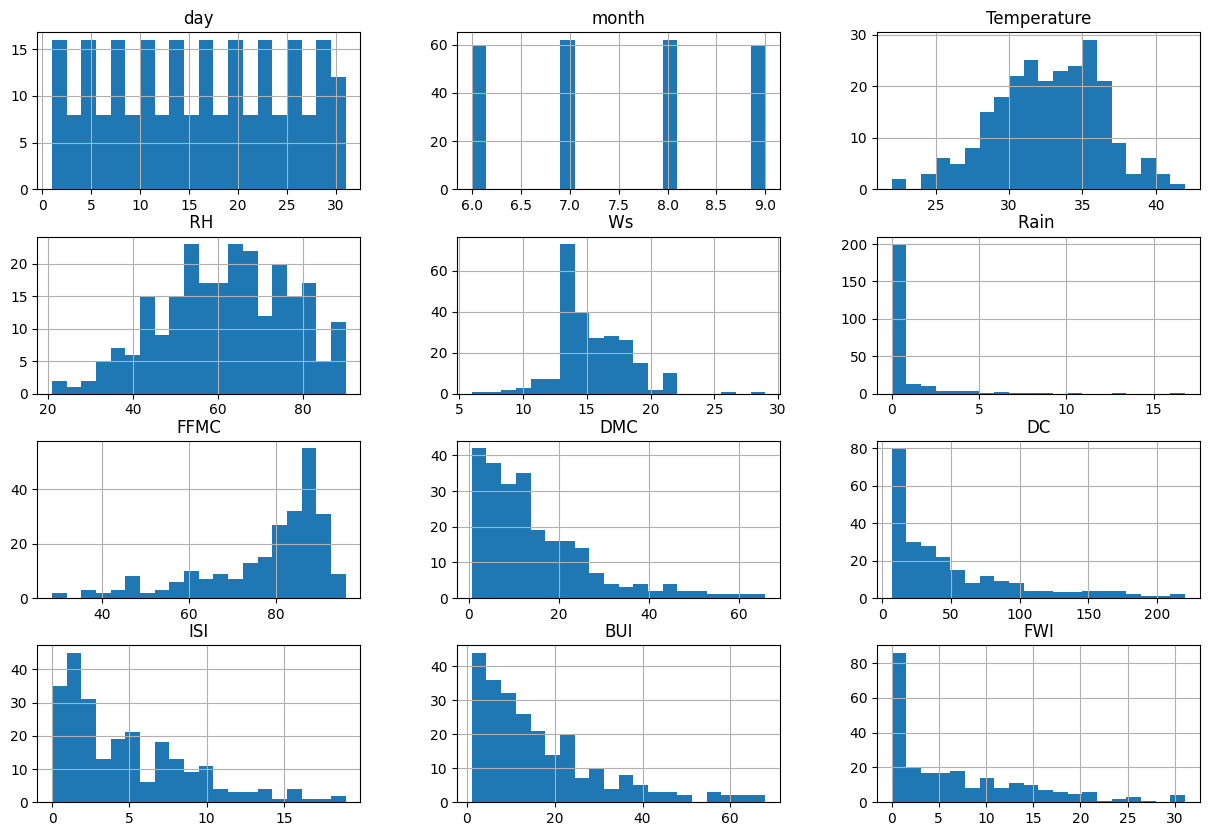

In [ ]:
X.hist(bins=20, figsize=(15, 10))
plt.show()

In [ ]:
pd.options.mode.copy_on_write = True

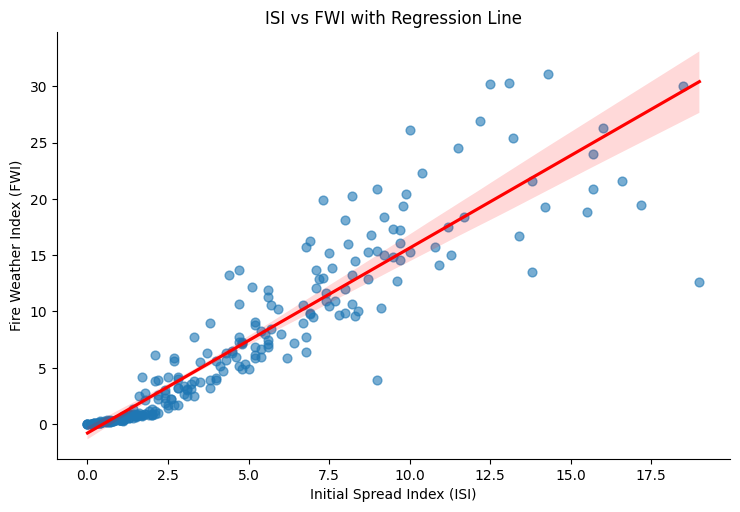

In [ ]:
sns.lmplot(x='ISI', y='FWI', data=X, height=5, aspect=1.5, line_kws={'color': 'red'}, scatter_kws={'s': 40, 'alpha': 0.6})
plt.title('ISI vs FWI with Regression Line')
plt.xlabel('Initial Spread Index (ISI)')
plt.ylabel('Fire Weather Index (FWI)')
plt.show()

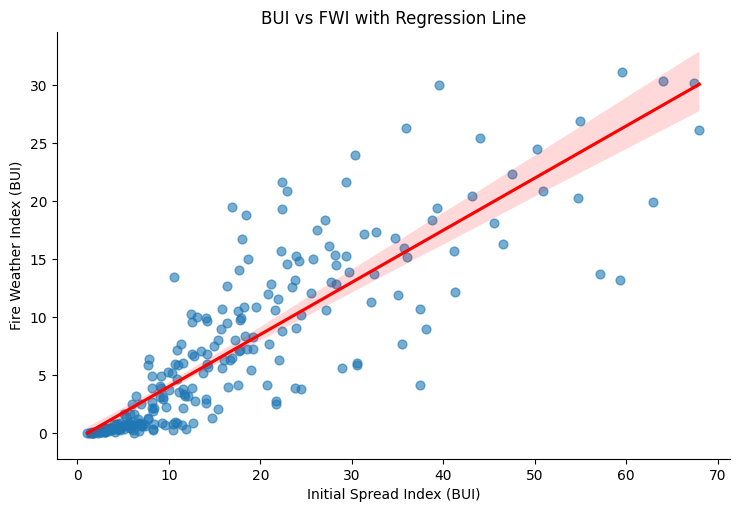

In [ ]:
sns.lmplot(x='BUI', y='FWI', data=X, height=5, aspect=1.5, line_kws={'color': 'red'}, scatter_kws={'s': 40, 'alpha': 0.6})
plt.title('BUI vs FWI with Regression Line')
plt.xlabel('Initial Spread Index (BUI)')
plt.ylabel('Fire Weather Index (BUI)')
plt.show()

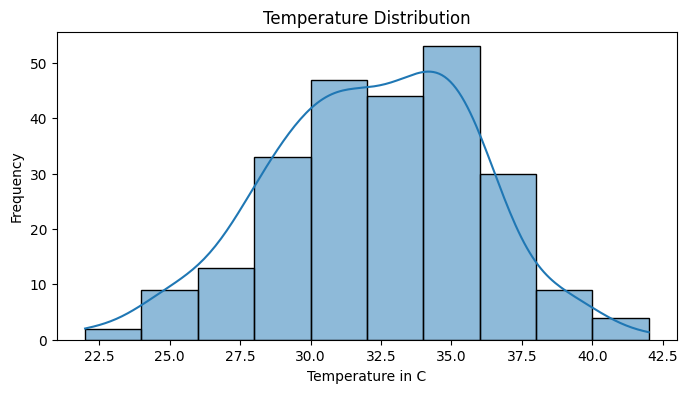

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(X['Temperature'], bins=10, kde=True)
plt.title('Temperature Distribution')
plt.xlabel('Temperature in C')
plt.ylabel('Frequency')
plt.show()

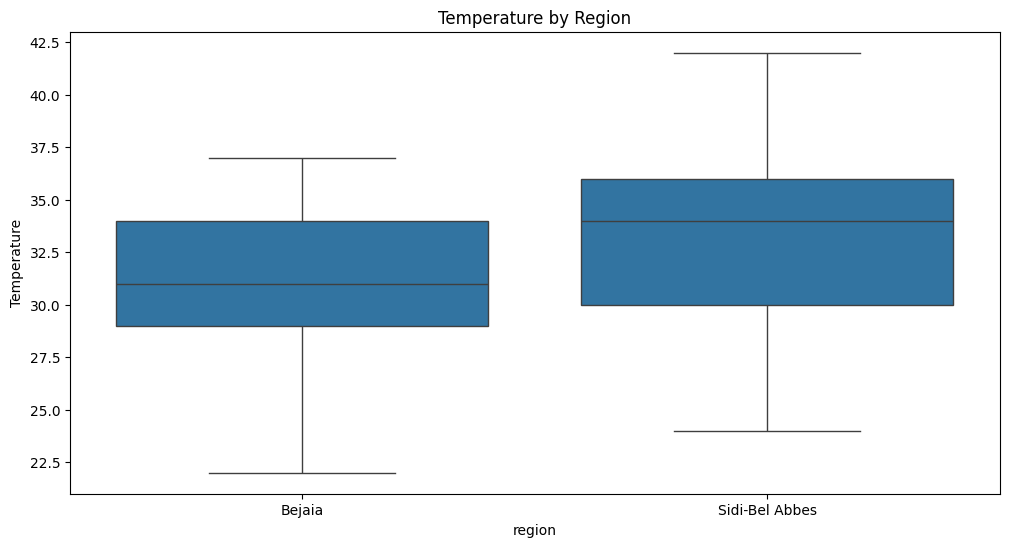

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='region', y='Temperature', data=X)
plt.title('Temperature by Region')
plt.show()

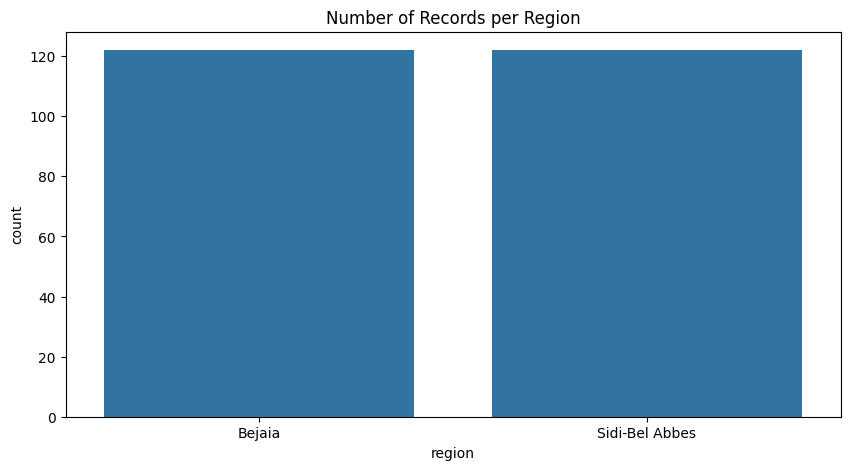

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x='region', data=X)
plt.title('Number of Records per Region')
plt.show()


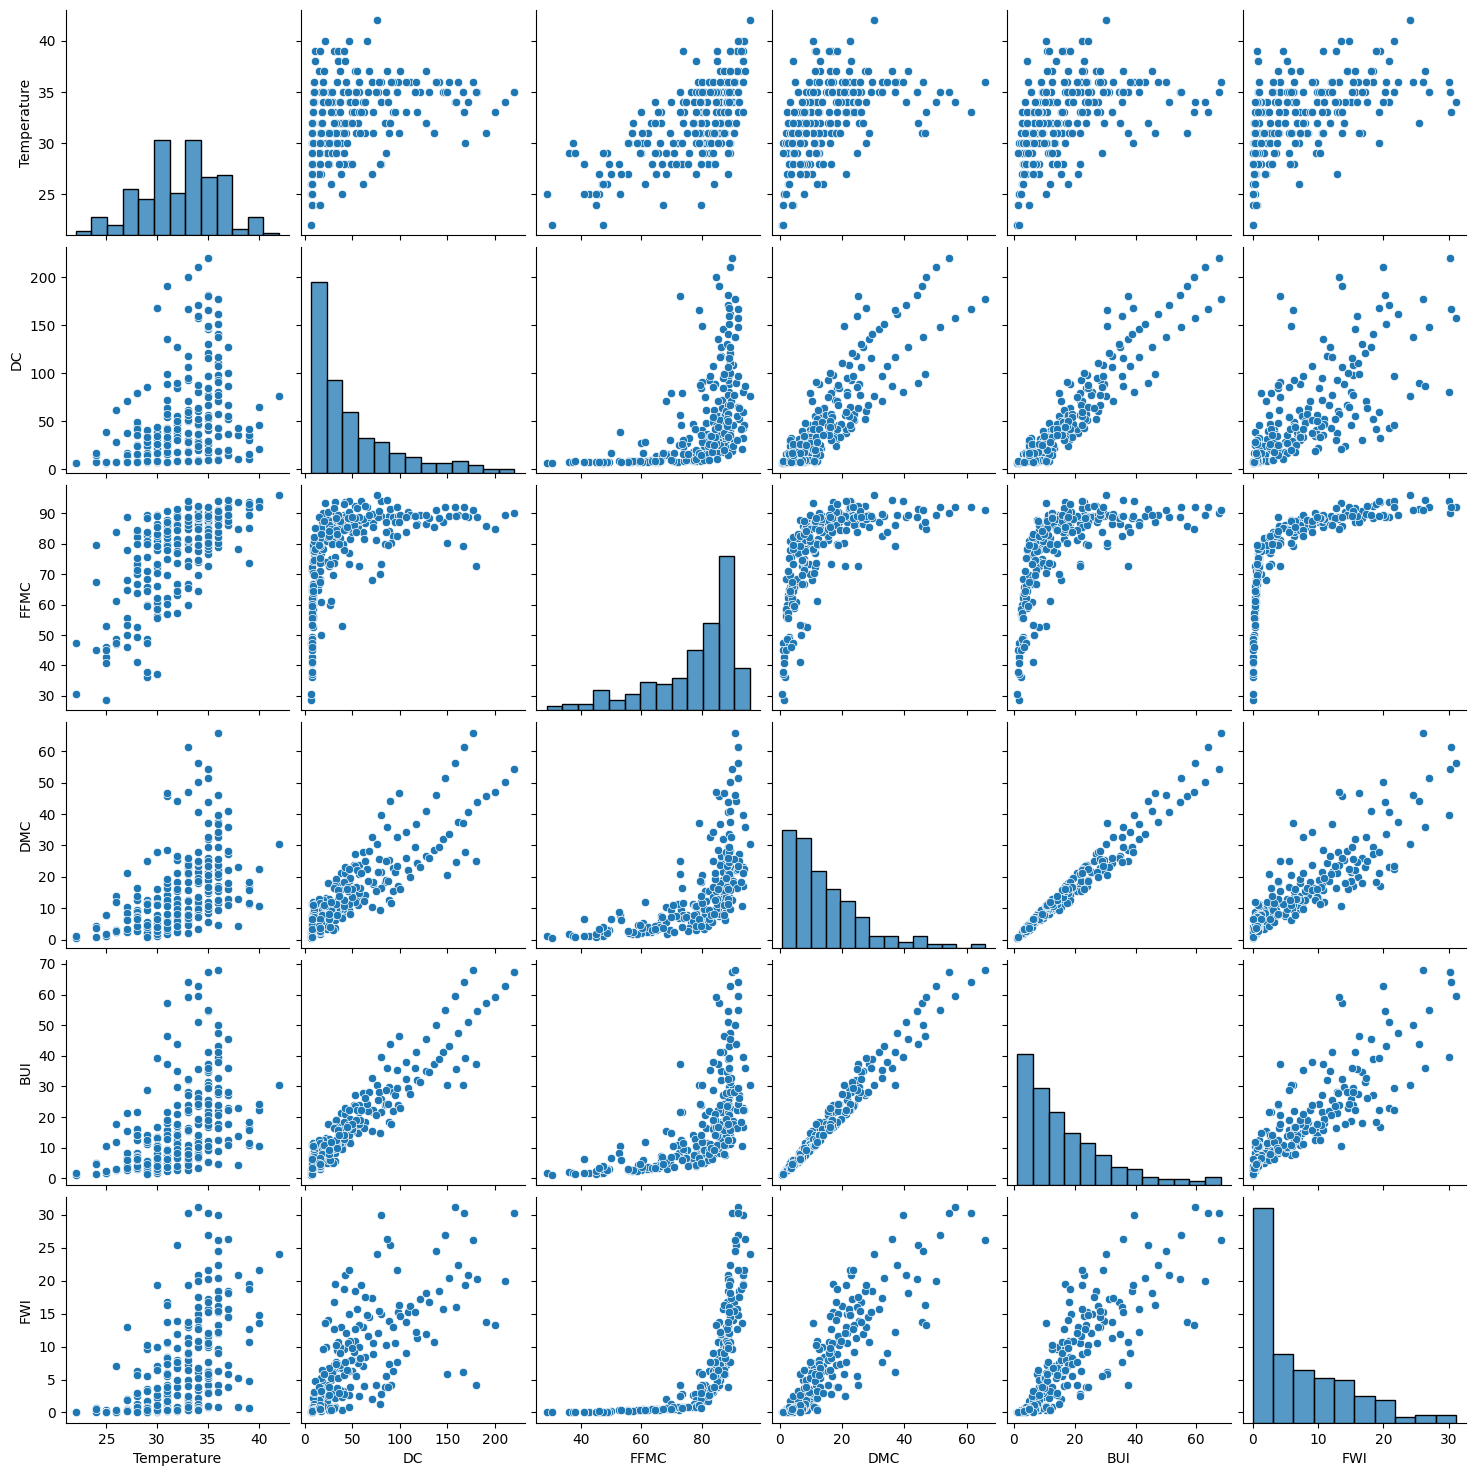

In [ ]:
sns.pairplot(X[['Temperature', 'DC', 'FFMC', 'DMC', 'BUI', 'FWI']])
plt.show()

<ipython-input-36-5fd50350e6e7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['FWI'] = pd.to_numeric(X['FWI'], errors='coerce')  # Converts to numeric, coercing errors to NaN if needed
<ipython-input-36-5fd50350e6e7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['FFMC'] = pd.to_numeric(X['FFMC'], errors='coerce')  # Same for FFMC


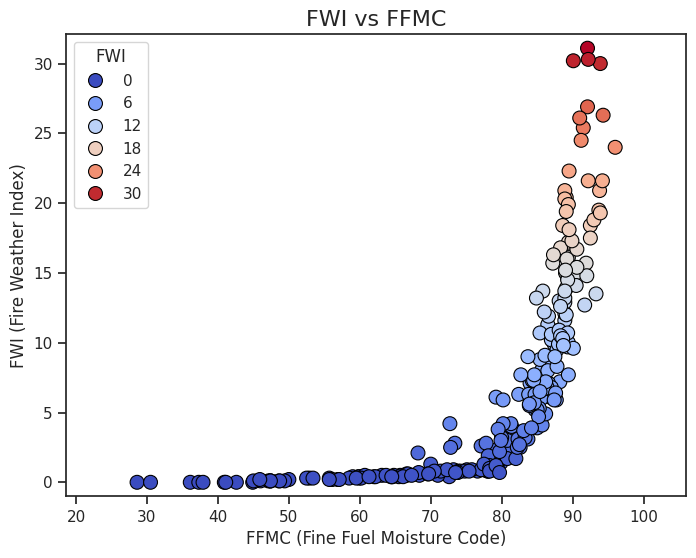

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


X['FWI'] = pd.to_numeric(X['FWI'], errors='coerce')
X['FFMC'] = pd.to_numeric(X['FFMC'], errors='coerce')

sns.set(style="ticks")


plt.figure(figsize=(8, 6))
sns.scatterplot(x=X['FFMC'], y=X['FWI'], hue=X['FWI'], palette="coolwarm", s=100, edgecolor='black')

plt.title('FWI vs FFMC', fontsize=16)
plt.xlabel('FFMC (Fine Fuel Moisture Code)', fontsize=12)
plt.ylabel('FWI (Fire Weather Index)', fontsize=12)


plt.xlim(X['FFMC'].min() - 10, X['FFMC'].max() + 10)
plt.ylim(X['FWI'].min() - 1, X['FWI'].max() + 1)


plt.show()


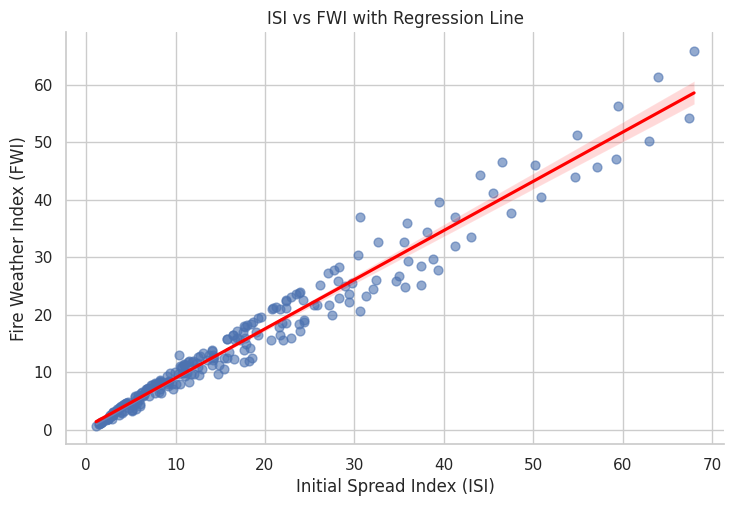

In [ ]:
sns.lmplot(x='BUI', y='DMC', data=X, height=5, aspect=1.5, line_kws={'color': 'red'}, scatter_kws={'s': 40, 'alpha': 0.6})
plt.title('ISI vs FWI with Regression Line')
plt.xlabel('Initial Spread Index (ISI)')
plt.ylabel('Fire Weather Index (FWI)')
plt.show()

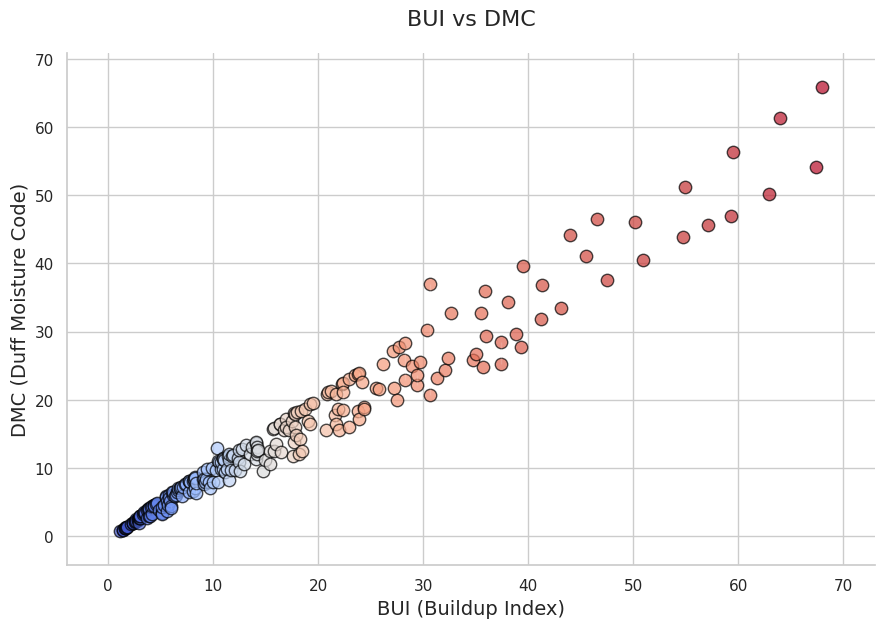

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set(style="whitegrid")


sns.lmplot(x='BUI', y='DMC', data=X, height=6, aspect=1.5,
           line_kws={'color': 'darkorange', 'linewidth': 2},
           scatter_kws={'s': 80, 'alpha': 0.7, 'edgecolor': 'black'},
           hue='BUI', palette='coolwarm', legend=False)

plt.title('BUI vs DMC', fontsize=16, pad=20)
plt.xlabel('BUI (Buildup Index)', fontsize=14)
plt.ylabel('DMC (Duff Moisture Code)', fontsize=14)
plt.xlim(X['BUI'].min() - 5, X['BUI'].max() + 5)
plt.ylim(X['DMC'].min() - 5, X['DMC'].max() + 5)
plt.show()


<ipython-input-50-039238822857>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['FWI'] = pd.to_numeric(X['FWI'], errors='coerce')
<ipython-input-50-039238822857>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['FFMC'] = pd.to_numeric(X['FFMC'], errors='coerce')


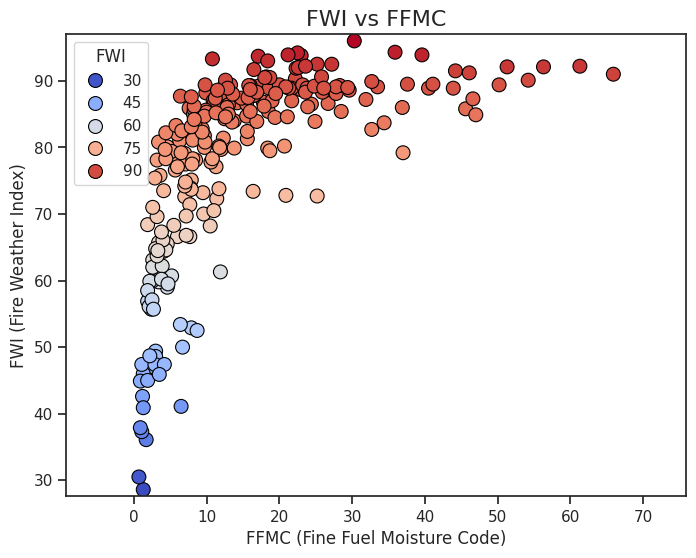

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

X['FWI'] = pd.to_numeric(X['FWI'], errors='coerce')
X['FFMC'] = pd.to_numeric(X['FFMC'], errors='coerce')

sns.set(style="ticks")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X['FFMC'], y=X['FWI'], hue=X['FWI'], palette="coolwarm", s=100, edgecolor='black')

plt.title('FWI vs FFMC', fontsize=16)
plt.xlabel('FFMC (Fine Fuel Moisture Code)', fontsize=12)
plt.ylabel('FWI (Fire Weather Index)', fontsize=12)

plt.xlim(X['FFMC'].min() - 10, X['FFMC'].max() + 10)
plt.ylim(X['FWI'].min() - 1, X['FWI'].max() + 1)

plt.show()


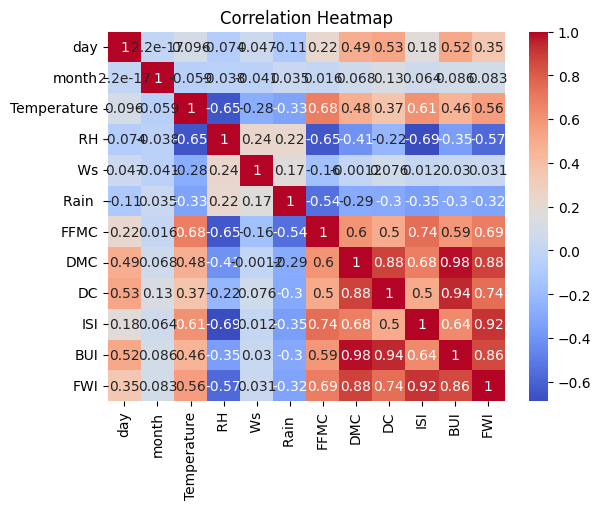

In [ ]:
heatmap = sns.heatmap(X.corr(numeric_only = True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Comparing the Two Regions

In [ ]:
bejaia_region_data = X[X['region'] == 'Bejaia']
bejaia_region_data = bejaia_region_data.drop('region', axis=1)
bejaia_region_data.describe()

,day,month,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
count,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,15.754098,7.500000,31.180328,67.975410,16.000000,0.842623,74.672951,12.314754,53.160656,3.655738,15.426230,5.577869
std,8.843274,1.115259,3.320401,11.154411,2.848807,2.409208,15.558713,11.274360,51.778265,3.021768,14.474302,6.343051
min,1.000000,6.000000,22.000000,45.000000,11.000000,0.000000,28.600000,0.700000,6.900000,0.000000,1.100000,0.000000
25%,8.000000,7.000000,29.000000,60.000000,14.000000,0.000000,65.925000,3.725000,10.050000,1.125000,5.100000,0.500000
50%,16.000000,7.500000,31.000000,68.000000,16.000000,0.000000,80.900000,9.450000,35.550000,2.650000,11.200000,3.000000
75%,23.000000,8.000000,34.000000,77.750000,18.000000,0.500000,86.775000,16.300000,79.025000,5.600000,21.675000,8.700000
max,31.000000,9.000000,37.000000,89.000000,26.000000,16.800000,90.300000,54.200000,220.400000,12.500000,67.400000,30.200000


In [ ]:
sidi_el_beida_region_data = X[X['region'] == 'Sidi-Bel Abbes']
sidi_el_beida_region_data = sidi_el_beida_region_data.drop('region', axis=1)
sidi_el_beida_region_data.describe()

,day,month,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI
count,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,15.754098,7.500000,33.163934,55.901639,15.008197,0.678689,81.102459,17.031967,45.415574,5.863934,17.920492,8.467428
std,8.843274,1.115259,3.675608,15.716186,2.692186,1.486759,12.244064,12.995068,42.927562,4.803667,13.870785,8.146170
min,1.000000,6.000000,24.000000,21.000000,6.000000,0.000000,37.900000,0.900000,7.300000,0.100000,1.400000,0.000000
25%,8.000000,7.000000,30.000000,43.250000,14.000000,0.000000,77.650000,7.325000,14.700000,1.825000,7.400000,0.925000
50%,16.000000,7.500000,34.000000,56.000000,15.000000,0.000000,84.850000,13.150000,31.500000,4.600000,13.900000,5.950000
75%,23.000000,8.000000,36.000000,66.750000,16.750000,0.475000,89.275000,22.900000,56.975000,8.625000,23.875000,13.650000
max,31.000000,9.000000,42.000000,90.000000,29.000000,8.700000,96.000000,65.900000,177.300000,19.000000,68.000000,31.100000


## Statistical Anlalysis

In [ ]:
mean_differnce = bejaia_region_data.mean() - sidi_el_beida_region_data.mean()
print(mean_differnce)

day             0.000000
month           0.000000
Temperature    -1.983607
 RH            12.073770
 Ws             0.991803
Rain            0.163934
FFMC           -6.429508
DMC            -4.717213
DC              7.745082
ISI            -2.208197
BUI            -2.494262
FWI            -2.889559
dtype: float64


In [ ]:
stat, p, dof, expected = sci.stats.chi2_contingency(class_proportions)
print(f"Chi-square statistic: {stat}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")

Chi-square statistic: 0.0
P-value: 1.0
Degrees of freedom: 0


### Chi-Squared and T-Test

In [ ]:
for col in X.columns:
  if X[col].dtype == 'object':
    contingency_table = pd.crosstab(y_cleaned, X[col])
    stat, p, dof, expected = sci.stats.chi2_contingency(contingency_table)
    print(f"Chi-square statistic for {col}: {stat}")
    print(f"P-value for {col}: {p}")
    print(f"Degrees of freedom for {col}: {dof}")
    if p < 0.05:
      print("There is a significant relationship between the feature and the target.")
    else:
      print("There is no significant relationship between the feature and the target.")

Chi-square statistic for region: 6.021602406343998
P-value for region: 0.014131809967792454
Degrees of freedom for region: 1
There is a significant relationship between the feature and the target.


In [ ]:
features = []
for col in bejaia_region_data.columns:
  features.append(col)


In [ ]:
for feature in features:
  bejaia_val = bejaia_region_data[feature]
  sidi_el_beida_val = sidi_el_beida_region_data[feature]

  t_stat, p_val = sci.stats.ttest_ind(bejaia_val, sidi_el_beida_val)
  print(f"T-statistic for {feature}: {t_stat}")
  print(f"P-value for {feature}: {p_val}")

  if p_val < 0.05:
    print(f"There's a significant difference in {feature} between the two regions.\n")
  else:
    print(f"No significant difference in {feature} between the two regions.\n")

T-statistic for day: 0.0
P-value for day: 1.0
No significant difference in day between the two regions.

T-statistic for month: 0.0
P-value for month: 1.0
No significant difference in month between the two regions.

T-statistic for Temperature: -4.423245277901117
P-value for Temperature: 1.4701908329832032e-05
There's a significant difference in Temperature between the two regions.

T-statistic for  RH: 6.919752268196396
P-value for  RH: 4.0247754558691433e-11
There's a significant difference in  RH between the two regions.

T-statistic for  Ws: 2.7948557821974904
P-value for  Ws: 0.005608494882213204
There's a significant difference in  Ws between the two regions.

T-statistic for Rain : 0.6395956378145556
P-value for Rain : 0.5230405194396232
No significant difference in Rain  between the two regions.

T-statistic for FFMC: -3.586904463111268
P-value for FFMC: 0.00040482848683777114
There's a significant difference in FFMC between the two regions.

T-statistic for DMC: -3.02853121576

## Functions

In [ ]:
def variance_filter(X):
    sel = VarianceThreshold(threshold=0.5)
    fitted_sel = sel.fit_transform(X)
    sel_idx = sel.get_support()
    removed_features = X.columns[~sel_idx]
    print("Removed Features:", removed_features)
    return fitted_sel, X.columns[sel_idx]



In [ ]:
def feature_selection(df, target, fs_type=2, rand_st=42):
    data_np = df.to_numpy()


    if fs_type == 2:
        clf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=3,
                                     criterion='entropy', random_state=rand_st)
        sel = SelectFromModel(clf, prefit=False, threshold='mean', max_features=None)
        fit_mod = sel.fit(data_np, target_np)
        sel_idx = fit_mod.get_support()

    elif fs_type == 4:
        clf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=3,
                                     criterion='entropy', random_state=rand_st)
        clf.fit(data_np, target_np)
        sel_idx = [1 if x >= np.mean(clf.feature_importances_) else 0 for x in clf.feature_importances_]

    temp = []
    temp_idx = []
    temp_del = []

    for i in range(len(data_np[0])):
        if sel_idx[i] == 1:
            temp.append(df.columns[i])
            temp_idx.append(i)
        else:
            temp_del.append(i)
    print("Selected features:", temp)
    print("Deleted features:", [df.columns[i] for i in temp_del])

    df_selected = df.iloc[:, temp_idx]

    return df_selected


In [ ]:
data_np_variance = variance_filter(X)[0]

Removed Features: Index(['region'], dtype='object')


### Feature Engineering Possibility

In [ ]:
def calculate_DSR(FWI):
    return 0.0272 * (FWI ** 1.77)

In [ ]:
X_engin = X.copy()
X_engin['DSR'] = X['FWI'].apply(calculate_DSR)

In [ ]:
X_engin

,region,day,month,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,DSR
0,1,1,6,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,0.007975
1,1,2,6,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,0.005373
2,1,3,6,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,0.000462
3,1,4,6,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,0.000000
4,1,5,6,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,0.007975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,0,26,9,30,65,14,0.0,85.4,16.0,44.5,4.5,16.9,6.5,0.747181
240,0,27,9,28,87,15,4.4,41.1,6.5,8.0,0.1,6.2,0.0,0.000000
241,0,28,9,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2,0.001575
242,0,29,9,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,0.014467


In [ ]:
data_np = feature_selection(X_engin, target_np, fs_type=2)

Selected features: ['FFMC', 'ISI', 'FWI', 'DSR']
Deleted features: ['region', 'day', 'month', 'Temperature', ' RH', ' Ws', 'Rain ', 'DMC', 'DC', 'BUI']


In [ ]:
scorers = {
    'Accuracy': 'accuracy',
    'roc_auc': 'roc_auc',
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score)
}

# SciKit Random Forest - Cross Val
start_ts = time.time()
clf = DecisionTreeClassifier(max_depth=None, criterion='entropy', random_state=1)
scores = cross_validate(estimator=clf, X=data_np, y=target_np, scoring=scorers, cv=5)

scores_Acc = scores['test_Accuracy']
print("Random Forest Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))

scores_AUC = scores['test_roc_auc']
print("Random Forest AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))

scores_Precision = scores['test_precision']
print("Random Forest Precision: %0.2f (+/- %0.2f)" % (scores_Precision.mean(), scores_Precision.std() * 2))

scores_F1 = scores['test_f1']
print("Random Forest F1 Score: %0.2f (+/- %0.2f)" % (scores_F1.mean(), scores_F1.std() * 2))

print("CV Runtime:", time.time() - start_ts)

Random Forest Acc: 0.96 (+/- 0.07)
Random Forest AUC: 0.96 (+/- 0.07)
Random Forest Precision: 0.95 (+/- 0.09)
Random Forest F1 Score: 0.96 (+/- 0.08)
CV Runtime: 0.08676576614379883


In [ ]:
scorers = {
    'Accuracy': 'accuracy',
    'roc_auc': 'roc_auc',
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score)
}

# SciKit Random Forest - Cross Val
start_ts = time.time()
clf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=3, criterion='entropy', random_state=1)
scores = cross_validate(estimator=clf, X=data_np, y=target_np, scoring=scorers, cv=5)

scores_Acc = scores['test_Accuracy']
print("Random Forest Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))

scores_AUC = scores['test_roc_auc']
print("Random Forest AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))

scores_Precision = scores['test_precision']
print("Random Forest Precision: %0.2f (+/- %0.2f)" % (scores_Precision.mean(), scores_Precision.std() * 2))

scores_F1 = scores['test_f1']
print("Random Forest F1 Score: %0.2f (+/- %0.2f)" % (scores_F1.mean(), scores_F1.std() * 2))

print("CV Runtime:", time.time() - start_ts)

Random Forest Acc: 0.98 (+/- 0.05)
Random Forest AUC: 1.00 (+/- 0.01)
Random Forest Precision: 0.99 (+/- 0.03)
Random Forest F1 Score: 0.98 (+/- 0.06)
CV Runtime: 0.8565082550048828


In [ ]:
scorers = {
    'Accuracy': 'accuracy',
    'roc_auc': 'roc_auc',
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score)
}

# SciKit Random Forest - Cross Val
start_ts = time.time()
clf = AdaBoostClassifier(n_estimators=100, random_state=1, learning_rate=0.01, algorithm='SAMME')
scores = cross_validate(estimator=clf, X=data_np, y=target_np, scoring=scorers, cv=5)

scores_Acc = scores['test_Accuracy']
print("Random Forest Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))

scores_AUC = scores['test_roc_auc']
print("Random Forest AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))

scores_Precision = scores['test_precision']
print("Random Forest Precision: %0.2f (+/- %0.2f)" % (scores_Precision.mean(), scores_Precision.std() * 2))

scores_F1 = scores['test_f1']
print("Random Forest F1 Score: %0.2f (+/- %0.2f)" % (scores_F1.mean(), scores_F1.std() * 2))

print("CV Runtime:", time.time() - start_ts)

Random Forest Acc: 0.97 (+/- 0.04)
Random Forest AUC: 1.00 (+/- 0.00)
Random Forest Precision: 0.97 (+/- 0.07)
Random Forest F1 Score: 0.97 (+/- 0.05)
CV Runtime: 1.1234791278839111


In [ ]:
scorers = {
    'Accuracy': 'accuracy',
    'roc_auc': 'roc_auc',
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score)
}

# SciKit Random Forest - Cross Val
start_ts = time.time()
clf=SVC(kernel='linear', gamma='scale', C=1.0, probability=True, random_state=1)
scores = cross_validate(estimator=clf, X=data_np, y=target_np, scoring=scorers, cv=5)

scores_Acc = scores['test_Accuracy']
print("Random Forest Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))

scores_AUC = scores['test_roc_auc']
print("Random Forest AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))

scores_Precision = scores['test_precision']
print("Random Forest Precision: %0.2f (+/- %0.2f)" % (scores_Precision.mean(), scores_Precision.std() * 2))

scores_F1 = scores['test_f1']
print("Random Forest F1 Score: %0.2f (+/- %0.2f)" % (scores_F1.mean(), scores_F1.std() * 2))

print("CV Runtime:", time.time() - start_ts)

Random Forest Acc: 0.98 (+/- 0.06)
Random Forest AUC: 1.00 (+/- 0.01)
Random Forest Precision: 0.97 (+/- 0.08)
Random Forest F1 Score: 0.97 (+/- 0.07)
CV Runtime: 0.06930804252624512


In [ ]:
scorers = {
    'Accuracy': 'accuracy',
    'roc_auc': 'roc_auc',
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score)
}

# SciKit Random Forest - Cross Val
start_ts = time.time()
clf=GaussianNB()
scores = cross_validate(estimator=clf, X=data_np, y=target_np, scoring=scorers, cv=5)

scores_Acc = scores['test_Accuracy']
print("Random Forest Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))

scores_AUC = scores['test_roc_auc']
print("Random Forest AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))

scores_Precision = scores['test_precision']
print("Random Forest Precision: %0.2f (+/- %0.2f)" % (scores_Precision.mean(), scores_Precision.std() * 2))

scores_F1 = scores['test_f1']
print("Random Forest F1 Score: %0.2f (+/- %0.2f)" % (scores_F1.mean(), scores_F1.std() * 2))

print("CV Runtime:", time.time() - start_ts)

Random Forest Acc: 0.95 (+/- 0.06)
Random Forest AUC: 0.99 (+/- 0.01)
Random Forest Precision: 0.93 (+/- 0.09)
Random Forest F1 Score: 0.94 (+/- 0.06)
CV Runtime: 0.07312440872192383


In [ ]:
scorers = {
    'Accuracy': 'accuracy',
    'roc_auc': 'roc_auc',
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score)
}

# SciKit Random Forest - Cross Val
start_ts = time.time()
clf=MultinomialNB()
scores = cross_validate(estimator=clf, X=data_np, y=target_np, scoring=scorers, cv=5)

scores_Acc = scores['test_Accuracy']
print("Random Forest Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))

scores_AUC = scores['test_roc_auc']
print("Random Forest AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))

scores_Precision = scores['test_precision']
print("Random Forest Precision: %0.2f (+/- %0.2f)" % (scores_Precision.mean(), scores_Precision.std() * 2))

scores_F1 = scores['test_f1']
print("Random Forest F1 Score: %0.2f (+/- %0.2f)" % (scores_F1.mean(), scores_F1.std() * 2))

print("CV Runtime:", time.time() - start_ts)

Random Forest Acc: 0.92 (+/- 0.09)
Random Forest AUC: 0.99 (+/- 0.02)
Random Forest Precision: 0.86 (+/- 0.15)
Random Forest F1 Score: 0.92 (+/- 0.09)
CV Runtime: 0.07621383666992188


# Feature Selection Model

In [ ]:
data_np = feature_selection(X, target_np, fs_type=2)

Selected features: ['FFMC', 'ISI', 'FWI']
Deleted features: ['region', 'day', 'month', 'Temperature', ' RH', ' Ws', 'Rain ', 'DMC', 'DC', 'BUI']


In [ ]:
data_train, data_test, target_train, target_test = train_test_split(data_np_variance, target_np, test_size=0.2)

In [ ]:
scorers = {
    'Accuracy': 'accuracy',
    'roc_auc': 'roc_auc',
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score)
}

# SciKit Random Forest - Cross Val
start_ts = time.time()
clf = DecisionTreeClassifier(max_depth=None, criterion='entropy', random_state=1)
scores = cross_validate(estimator=clf, X=data_np, y=target_np, scoring=scorers, cv=5)

scores_Acc = scores['test_Accuracy']
print("Random Forest Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))

scores_AUC = scores['test_roc_auc']
print("Random Forest AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))

scores_Precision = scores['test_precision']
print("Random Forest Precision: %0.2f (+/- %0.2f)" % (scores_Precision.mean(), scores_Precision.std() * 2))

scores_F1 = scores['test_f1']
print("Random Forest F1 Score: %0.2f (+/- %0.2f)" % (scores_F1.mean(), scores_F1.std() * 2))

print("CV Runtime:", time.time() - start_ts)

Random Forest Acc: 0.97 (+/- 0.06)
Random Forest AUC: 0.97 (+/- 0.05)
Random Forest Precision: 0.95 (+/- 0.12)
Random Forest F1 Score: 0.96 (+/- 0.06)
CV Runtime: 0.1713392734527588


In [ ]:
scorers = {
    'Accuracy': 'accuracy',
    'roc_auc': 'roc_auc',
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score)
}

# SciKit Random Forest - Cross Val
start_ts = time.time()
clf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=3, criterion='entropy', random_state=1)
scores = cross_validate(estimator=clf, X=data_np, y=target_np, scoring=scorers, cv=5)

scores_Acc = scores['test_Accuracy']
print("Random Forest Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))

scores_AUC = scores['test_roc_auc']
print("Random Forest AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))

scores_Precision = scores['test_precision']
print("Random Forest Precision: %0.2f (+/- %0.2f)" % (scores_Precision.mean(), scores_Precision.std() * 2))

scores_F1 = scores['test_f1']
print("Random Forest F1 Score: %0.2f (+/- %0.2f)" % (scores_F1.mean(), scores_F1.std() * 2))

print("CV Runtime:", time.time() - start_ts)

Random Forest Acc: 0.98 (+/- 0.05)
Random Forest AUC: 1.00 (+/- 0.01)
Random Forest Precision: 0.99 (+/- 0.03)
Random Forest F1 Score: 0.98 (+/- 0.06)
CV Runtime: 2.1565935611724854


In [ ]:
scorers = {
    'Accuracy': 'accuracy',
    'roc_auc': 'roc_auc',
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score)
}

# SciKit Random Forest - Cross Val
start_ts = time.time()
clf = AdaBoostClassifier(n_estimators=100, random_state=1, learning_rate=0.01, algorithm='SAMME')
scores = cross_validate(estimator=clf, X=data_np, y=target_np, scoring=scorers, cv=5)

scores_Acc = scores['test_Accuracy']
print("Random Forest Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))

scores_AUC = scores['test_roc_auc']
print("Random Forest AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))

scores_Precision = scores['test_precision']
print("Random Forest Precision: %0.2f (+/- %0.2f)" % (scores_Precision.mean(), scores_Precision.std() * 2))

scores_F1 = scores['test_f1']
print("Random Forest F1 Score: %0.2f (+/- %0.2f)" % (scores_F1.mean(), scores_F1.std() * 2))

print("CV Runtime:", time.time() - start_ts)

Random Forest Acc: 0.97 (+/- 0.04)
Random Forest AUC: 1.00 (+/- 0.00)
Random Forest Precision: 0.97 (+/- 0.07)
Random Forest F1 Score: 0.97 (+/- 0.05)
CV Runtime: 2.514265537261963


In [ ]:
scorers = {
    'Accuracy': 'accuracy',
    'roc_auc': 'roc_auc',
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score)
}

# SciKit Random Forest - Cross Val
start_ts = time.time()
clf=SVC(kernel='linear', gamma='scale', C=1.0, probability=True, random_state=1)
scores = cross_validate(estimator=clf, X=data_np, y=target_np, scoring=scorers, cv=5)

scores_Acc = scores['test_Accuracy']
print("Random Forest Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))

scores_AUC = scores['test_roc_auc']
print("Random Forest AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))

scores_Precision = scores['test_precision']
print("Random Forest Precision: %0.2f (+/- %0.2f)" % (scores_Precision.mean(), scores_Precision.std() * 2))

scores_F1 = scores['test_f1']
print("Random Forest F1 Score: %0.2f (+/- %0.2f)" % (scores_F1.mean(), scores_F1.std() * 2))

print("CV Runtime:", time.time() - start_ts)

Random Forest Acc: 0.98 (+/- 0.06)
Random Forest AUC: 1.00 (+/- 0.01)
Random Forest Precision: 0.97 (+/- 0.08)
Random Forest F1 Score: 0.97 (+/- 0.07)
CV Runtime: 0.34288716316223145


In [ ]:
scorers = {
    'Accuracy': 'accuracy',
    'roc_auc': 'roc_auc',
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score)
}

# SciKit Random Forest - Cross Val
start_ts = time.time()
clf=GaussianNB()
scores = cross_validate(estimator=clf, X=data_np, y=target_np, scoring=scorers, cv=5)

scores_Acc = scores['test_Accuracy']
print("Random Forest Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))

scores_AUC = scores['test_roc_auc']
print("Random Forest AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))

scores_Precision = scores['test_precision']
print("Random Forest Precision: %0.2f (+/- %0.2f)" % (scores_Precision.mean(), scores_Precision.std() * 2))

scores_F1 = scores['test_f1']
print("Random Forest F1 Score: %0.2f (+/- %0.2f)" % (scores_F1.mean(), scores_F1.std() * 2))

print("CV Runtime:", time.time() - start_ts)

Random Forest Acc: 0.97 (+/- 0.04)
Random Forest AUC: 1.00 (+/- 0.01)
Random Forest Precision: 0.96 (+/- 0.06)
Random Forest F1 Score: 0.97 (+/- 0.05)
CV Runtime: 0.12996840476989746


In [ ]:
scorers = {
    'Accuracy': 'accuracy',
    'roc_auc': 'roc_auc',
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score)
}

# SciKit Random Forest - Cross Val
start_ts = time.time()
clf=MultinomialNB()
scores = cross_validate(estimator=clf, X=data_np, y=target_np, scoring=scorers, cv=5)

scores_Acc = scores['test_Accuracy']
print("Random Forest Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))

scores_AUC = scores['test_roc_auc']
print("Random Forest AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))

scores_Precision = scores['test_precision']
print("Random Forest Precision: %0.2f (+/- %0.2f)" % (scores_Precision.mean(), scores_Precision.std() * 2))

scores_F1 = scores['test_f1']
print("Random Forest F1 Score: %0.2f (+/- %0.2f)" % (scores_F1.mean(), scores_F1.std() * 2))

print("CV Runtime:", time.time() - start_ts)

Random Forest Acc: 0.93 (+/- 0.09)
Random Forest AUC: 0.99 (+/- 0.02)
Random Forest Precision: 0.87 (+/- 0.14)
Random Forest F1 Score: 0.92 (+/- 0.09)
CV Runtime: 0.12680339813232422


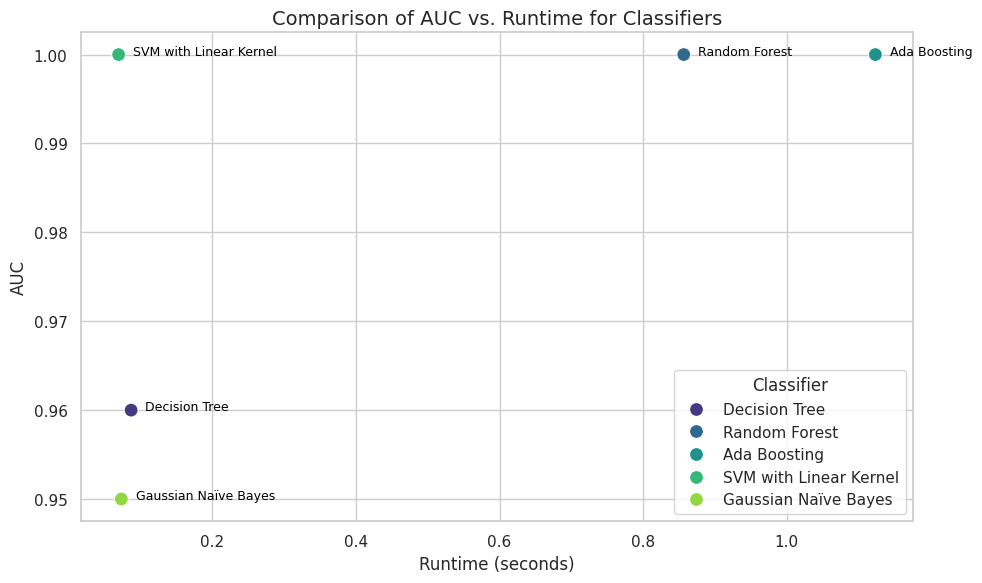

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Data
data = {
    'Classifier': ['Decision Tree', 'Random Forest', 'Ada Boosting', 'SVM with Linear Kernel', 'Gaussian Naïve Bayes'],
    'AUC': [0.96, 1.00, 1.00, 1.00, 0.95],
    'Runtime': [0.08676576614379883, 0.8565082550048828, 1.1234791278839111, 0.06930804252624512, 0.07312440872192383]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Initialize the Seaborn style
sns.set_theme(style="whitegrid")

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=df,
    x='Runtime',
    y='AUC',
    hue='Classifier',
    palette='viridis',
    s=100,
    legend='full'
)

# Add annotations for each point
for i in range(len(df)):
    plt.text(
        x=df['Runtime'][i] + 0.02,
        y=df['AUC'][i],
        s=df['Classifier'][i],
        fontsize=9,
        color='black'
    )

# Label axes and add a title
plt.title('Comparison of AUC vs. Runtime for Classifiers', fontsize=14)
plt.xlabel('Runtime (seconds)', fontsize=12)
plt.ylabel('AUC', fontsize=12)

# Show plot
plt.tight_layout()
plt.show()
